# Example1: Principal Component Analysis (PCA) 


<a href="https://colab.research.google.com/github/PGM-Lab/ProbModelingDNNs/blob/master/notebooks/Example1-PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Principal Component Analysis (PCA) is a classic statistical technique for dimensionality reduction. It defines a mapping between the $d$-dimensional data-representation of a point $\boldsymbol{x}$ and its $k$-dimensional latent representation, $\boldsymbol{z}$. The latent representation is known as the scores, and the affine transformation is performed using the loading matrix $\boldsymbol{\beta}$, which has dimensions $k\times d$. 


A simplified probabilistic view of PCA (Tipping & Bishop, 1999) is given below, which provides a pseudo-code a description of the generative model of a probabilistic PCA model.

<img src="https://raw.githubusercontent.com/PGM-Lab/ProbModelingDNNs/master/img/pca_pseudocode.png" alt="PCA-pseudocode" style="width: 700px;"/>


The present notebook experimentally illustrates the behavior of Probabilistic PCA as a feature reduction method on (a reduced version of) MNIST dataset. The model is implemented using the Edward2 from tensorflow-probability.

## Setting up the system

First, we will install and import the required packages as follows.



In [16]:
!pip install tensorflow
!pip install tensorflow-probability
!pip install keras
!pip install matplotlib
!pip install inferpy==1.1.0
!pip install setuptools
!pip install pandas

In [5]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.datasets import mnist
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Global configuration
num_epochs = 3000
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01


## Data 

For illustrating purposes, the MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the ``inferpy`` package (and hence from keras):

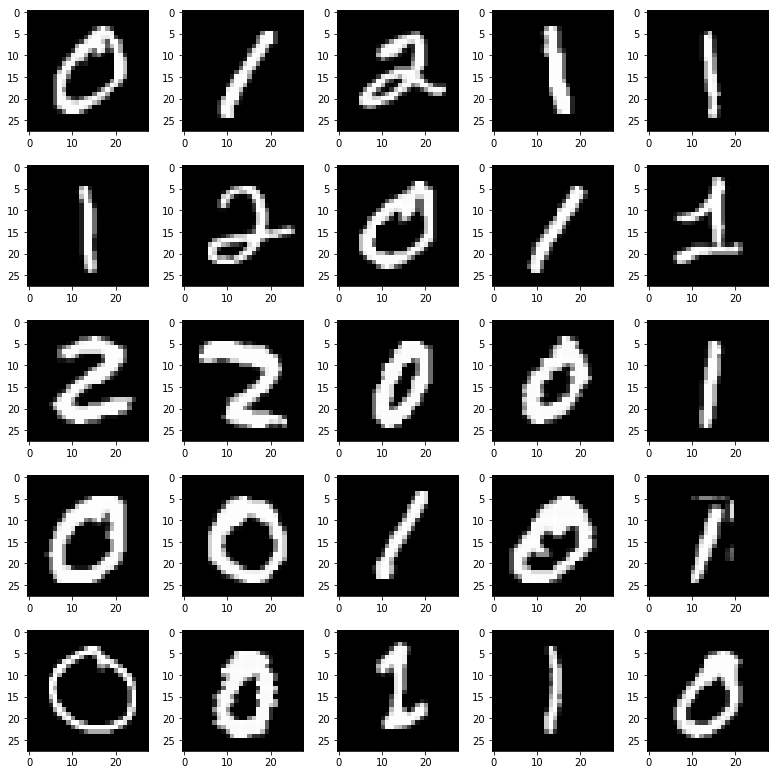

In [6]:
# number of observations (dataset size)
N = 1000
# digits considered
DIG = [0,1,2]

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(x_train, grid=[5,5])

### Model definition

The implementation for the generative model for a PCA model (Algorithm 1) is defined below. The input parameters are: `k` is the latent dimension, `d` is the data-dimension and `N`the number of samples or data instances. 

In [7]:
# Model constants
k, d = 2, np.shape(x_train)[-1]

def pca(k,d,N):

    # Define local latent variables
    z = ed.Normal(loc=tf.zeros([k]), scale=1., sample_shape=N, name="z")

    # Define the weights
    beta = ed.Normal(loc=tf.zeros([k, d]), scale=1., name="beta")
    
    # Define local random variables
    x = ed.Normal(loc=z @ beta, scale=1., name="x")  # N,k  @ k,d  +  N,d

    return z, beta, x


print(pca)

<function pca at 0x130dfa9d8>


This is a latent variable model (LVM) where the latent representation $\boldsymbol{z}$ is known as the scores, and the affine transformation is performed using the loading matrix  $\boldsymbol{\beta}$.

### Inference

Variational inference is a deterministic technique that finds a tractable approximation to an intractable (posterior) distribution. 
We will use $q$ to denote the approximation, and use $p$ to signify the true distribution (like $p(\boldsymbol{\beta},\boldsymbol{z}|\boldsymbol{x})$ in the example above).
More specifically, ${\cal Q}$ will denote a set of possible approximations $q$.

In practice, we define a generative model for sampling from $q(\boldsymbol{\beta},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$, where $\boldsymbol{\lambda}, \boldsymbol{\phi}$ are the variational parameters to optimise.





In [8]:
def Q(k, d, N):

    qz_loc = tf.Variable(tf.zeros([N, k]))
    qz_scale = tf.math.softplus(tf.Variable(tf.ones([N, k])))
    qz = ed.Normal(loc=qz_loc, scale=qz_scale, name="qz")

    qbeta_loc = tf.Variable(tf.zeros([k, d]))
    qbeta_scale = tf.math.softplus(tf.Variable(tf.ones([k, d])))
    qbeta = ed.Normal(loc=qbeta_loc, scale=qbeta_scale, name="qbeta")

    return qz, qbeta


print(Q)

<function Q at 0x1339b4268>


Variational methods adjusts the parameters by maximizing the ELBO (Evidence LOwer Bound) denoted $\cal{L}$ and expressed as 

$\cal{L}(\boldsymbol{\lambda},\boldsymbol{\phi})  = \mathbb{E}_q [\ln p(\boldsymbol{x}, \boldsymbol{z}, \boldsymbol{beta})] - \mathbb{E}_q [\ln q(\boldsymbol{beta},\boldsymbol{z}|\boldsymbol{\lambda},\boldsymbol{\phi})]$

In Edward, this is done as follows.

In [9]:
def set_values(**model_kwargs):
    def interceptor(f, *args, **kwargs):
        name = kwargs.get("name")
        if name in model_kwargs:
            kwargs["value"] = model_kwargs[name]
        else:
            print(f"set_values not interested in {name}.")
        return ed.interceptable(f)(*args, **kwargs)
    return interceptor


qz, qbeta = Q(k, d, N)

with ed.interception(set_values(beta=qbeta, z=qz, x=x_train)):
    pz, pbeta, px = pca(k, d, N)

energy = tf.reduce_sum(pbeta.distribution.log_prob(pbeta.value)) + \
         tf.reduce_sum(pz.distribution.log_prob(pz.value)) + \
         tf.reduce_sum(px.distribution.log_prob(px.value))

entropy = tf.reduce_sum(qbeta.distribution.log_prob(qbeta.value)) + \
          tf.reduce_sum(qz.distribution.log_prob(qz.value))

elbo = energy - entropy

print(elbo)

Tensor("sub:0", shape=(), dtype=float32)


Finally, the ELBO function is maximized.

In [18]:
with tf.Session() as sess:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    t = []
    train = optimizer.minimize(-elbo)
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(num_epochs+1):
        t.append(sess.run(elbo))
        sess.run(train)
        if verbose:
            if i % 10 == 0: print(".", end="", flush=True)
            if i % 200 == 0:
                str_elbo = str(t[-1] / 1000) + " k"
                print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

        # Extract the posterior
                
        post = {"z": sess.run(qz.distribution.loc),
        "beta": sess.run(qbeta.distribution.loc),
               }

# save the ELBO evolution
data = pd.DataFrame({"elbo": t})
data.to_csv(f"./res/elbo_pca.csv")
        

.
0 epochs	-2903628.288 k....................
200 epochs	-2577143.808 k....................
400 epochs	-1916633.472 k....................
600 epochs	-1668244.352 k....................
800 epochs	-1606040.96 k....................
1000 epochs	-1588505.216 k....................
1200 epochs	-1565060.224 k....................
1400 epochs	-1473596.672 k....................
1600 epochs	-1347236.096 k....................
1800 epochs	-1292071.424 k....................
2000 epochs	-1274892.672 k....................
2200 epochs	-1268847.616 k....................
2400 epochs	-1266292.352 k....................
2600 epochs	-1265238.4 k....................
2800 epochs	-1264837.376 k....................
3000 epochs	-1264516.224 k

After the inference, we can plot the hidden representation:

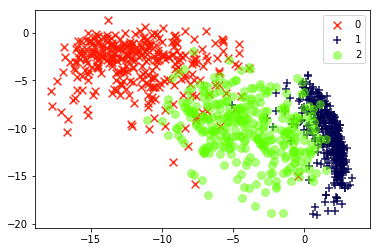

In [14]:
markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()
fig.savefig("../img/pca_mnist.pdf")

## Test

For testing our model, we will generate samples of $\boldsymbol{x}$ given the infered posterior distributions.

set_values not interested in x.


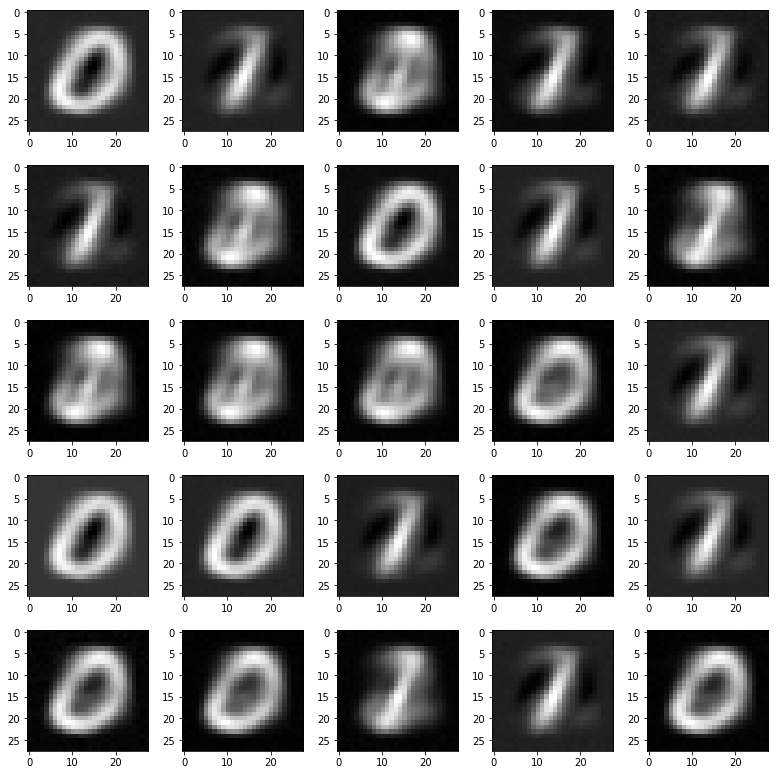

In [12]:

with ed.interception(set_values(**post)):
    generate = pca(k,d,N)

with tf.Session() as sess:
    _, _, x_gen = sess.run(generate)


# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])